In [260]:
from matplotlib import pyplot as plt
%matplotlib inline
from matplotlib import style
style.use('seaborn-talk')
from matplotlib import cm
import numpy as np
import os
import scipy.io
import seaborn as sb
from scipy.fftpack import fft
import csv
import pandas as pd
from scipy.signal import butter, filtfilt
import glob

In [269]:
# Pathways
outpath = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Method_Fig/'
figpath = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Tortuosity_Fig/'
outpath_ = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Tortuosity/'
outpath_2 = '/Users/Mahad/Documents/GitHub2/ManducaMultiSenseFeeding/Tortuosity_Fig/Scatter/'

In [3]:
def mean(numbers):
    return float(sum(numbers)) / max(len(numbers), 1)

In [ ]:
def jitter(number):
    j_int = number+0.1*np.random.randn(1)
    return j_int

In [4]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [5]:
#  Here we implement a butterworth filter.  Kinda a useful beast for smoothing data.  
# We are creating a bandstop filter to get rid of wing beat frequesicies.

def butter_bandstop(fs, order=5):
    nyq = 0.5 * fs
    low = 22 / nyq
    high = 28 / nyq
    b, a = butter(order, [low, high], btype='bandstop', analog=False)
    return b, a

def butter_bandstop_filter(data, fs, order=5):
    b, a = butter_bandstop(fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [273]:
def GetStartStopFrame(test):
    test = np.asarray(test)
    c = np.where(np.isnan(test))[0]
    d = c[1:] - c[:-1] # find the edges where NaN's are - all continous NaNs will have 1 but non 
                    # contonous ones will have higher than 1
    if len(d) == 0:
        start_ind = 0
        stop_ind = len(test) - 1
    else:
        idx = np.argmax(d) # find the biggest continous block of non NaNs
        start_ind = c[idx] + 1 # start from one frame after the NaN
        stop_ind = c[idx + 1] - 1 # stop one frame before NaN

    return(start_ind, stop_ind)

In [6]:
def Tortuosity(df):
    
    pre_t = df.loc[:,'FrameNumber']
    t = pre_t/100
    xvel = df.loc[:,'X_position']
    yvel = df.loc[:,'Y_position']
    
    Nx = len(xvel)  #number of points
    Nt = Nx
    Time = t.values[-1]-t.values[0]   #total sample time (in seconds)c
    fs = Nx/Time   # sample frequency
    TT = 1/fs  #delta t.
    list(xvel)
    meanxvel = mean(xvel)
    
    # . fftxvel is complex with real and imaginary part.
    #Nyquist spacing (first half of Fourier) -- the list of frequencies for which we have Fourier coefficients
    fftxvel = fft(xvel-meanxvel)    # this is the Fourier tranform of the x velocity
    xf = np.linspace(0.0, 1.0/(2.0*TT), Nx//2)  
    
    order = 5
    cutoff = 5
    
    pre_conditioned_xvel = butter_bandstop_filter(xvel, fs, order)
    
    conditioned_xvel = butter_highpass_filter(pre_conditioned_xvel, cutoff, fs, order)

    
    stdxv = np.std(conditioned_xvel)
    meanxv = np.mean(xvel)
    turb_intens = stdxv/meanxv
    
    fft_Cxvel = fft(conditioned_xvel)
    
    return xf, Nx, fft_Cxvel, stdxv, meanxv, turb_intens, conditioned_xvel

In [101]:
csv_list = glob.glob(outpath + '*Trial*.csv')
print(len(csv_list))

38


_L0.1_c-3_m12


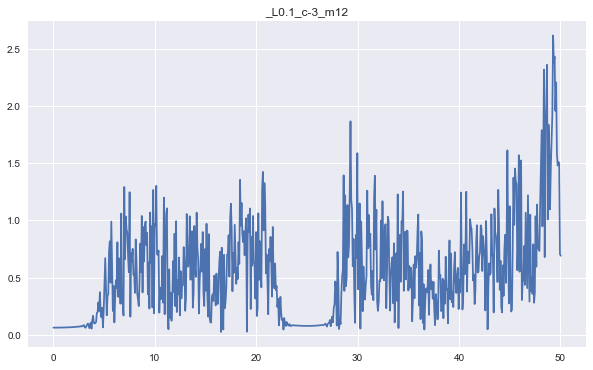

_L0.1_c-3_m2


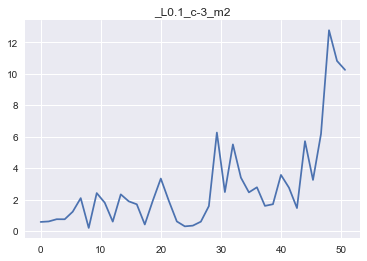

_L0.1_c-3_m20


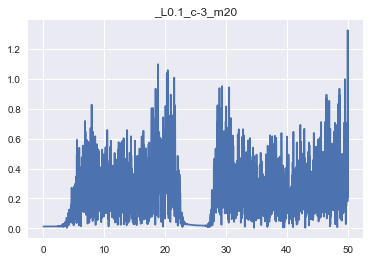

_L0.1_c-3_m21


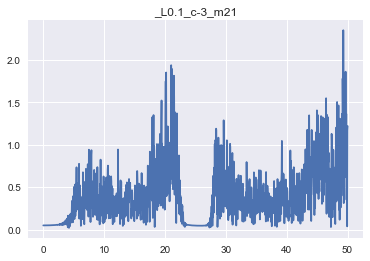

_L0.1_c-3_m22


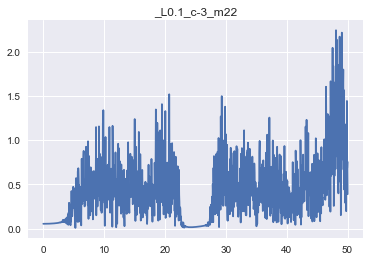

_L0.1_c-3_m23


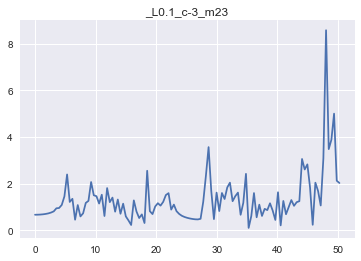

_L0.1_c-3_m24


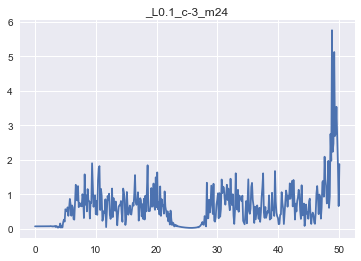

_L0.1_c-3_m25


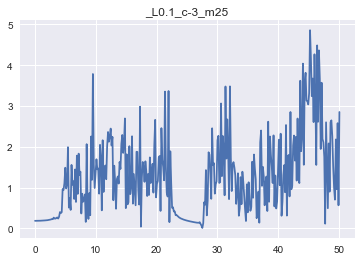

_L0.1_c-3_m8


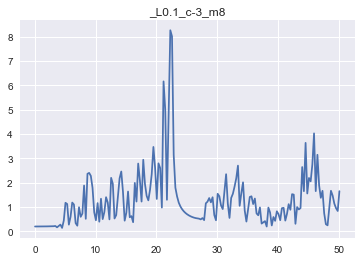

_L50_c-3_m10


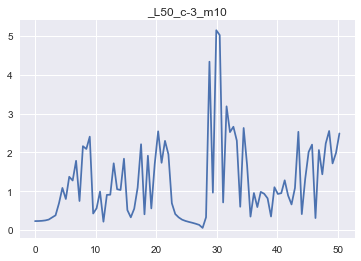

_L50_c-3_m12


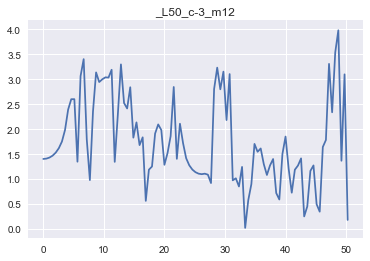

_L50_c-3_m13


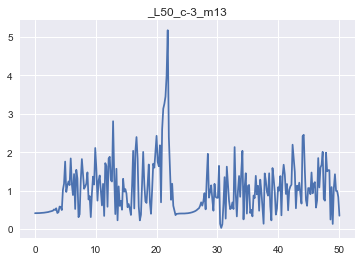

_L50_c-3_m14


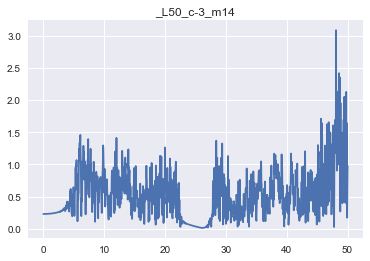

_L50_c-3_m15


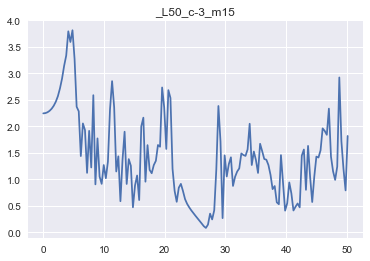

_L50_c-3_m21


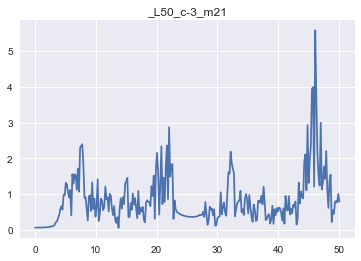

_L50_c-3_m22


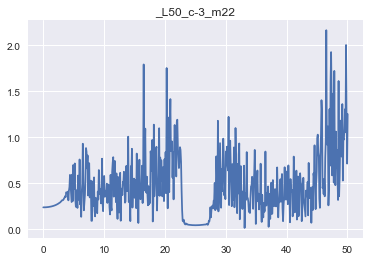

_L50_c-3_m24


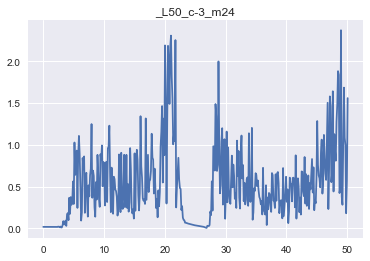

_L50_c-3_m6


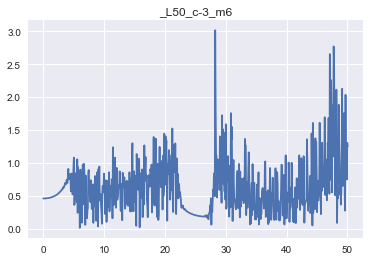

L0.1_c-3_m12


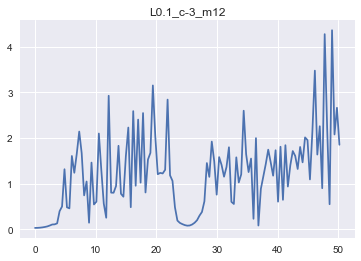

L0.1_c-3_m2


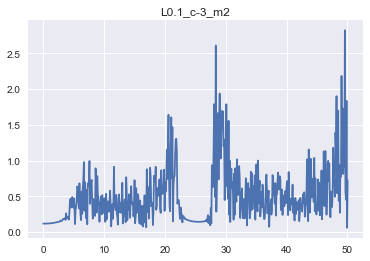

L0.1_c-3_m20


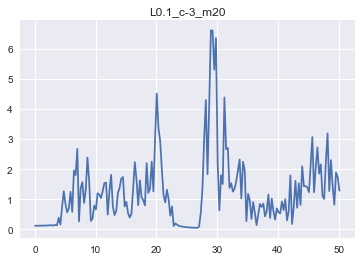

L0.1_c-3_m21


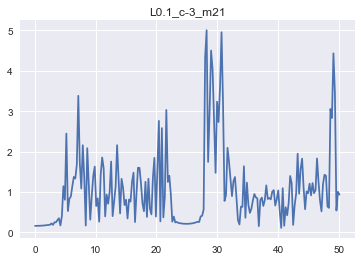

L0.1_c-3_m22


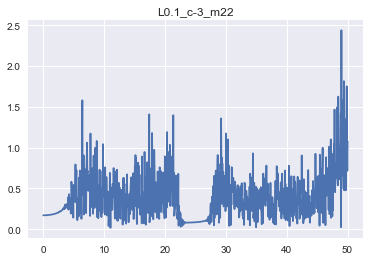

L0.1_c-3_m23


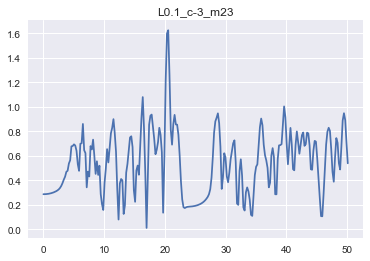

L0.1_c-3_m24


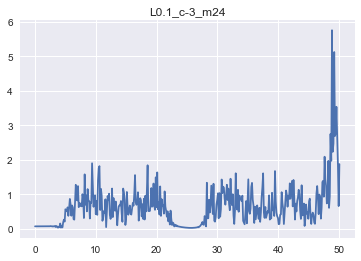

L0.1_c-3_m25


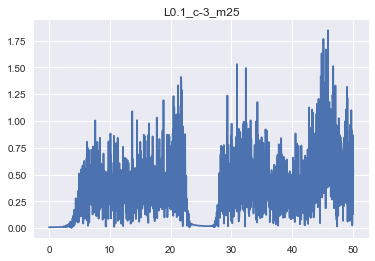

L0.1_c-3_m8


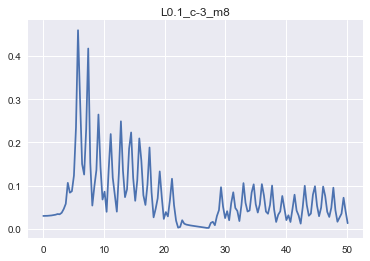

L50_c-3_m10


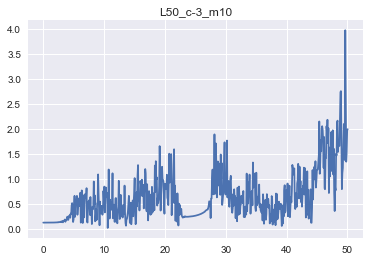

L50_c-3_m12


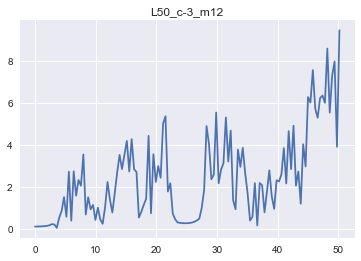

L50_c-3_m13


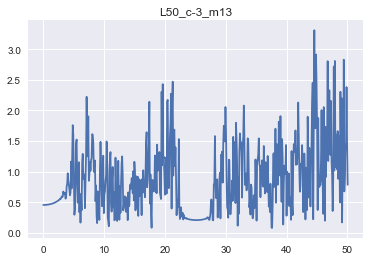

L50_c-3_m14


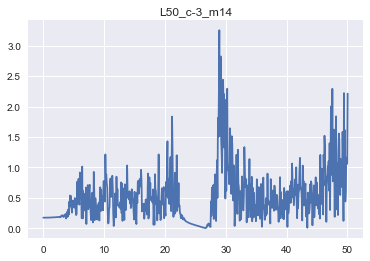

L50_c-3_m15


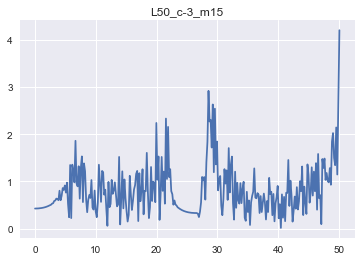

L50_c-3_m2


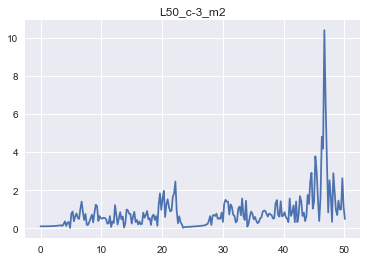

L50_c-3_m21


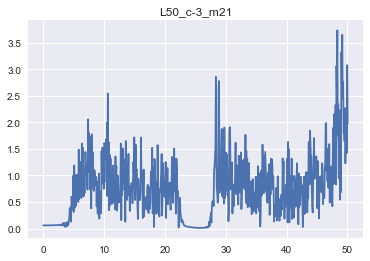

L50_c-3_m22


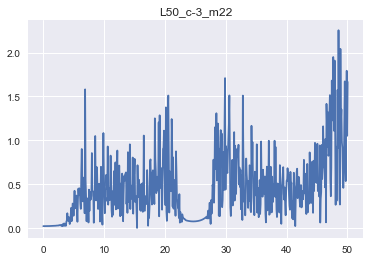

L50_c-3_m24


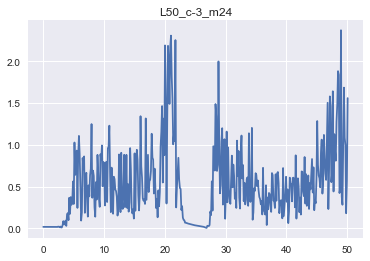

L50_c-3_m6


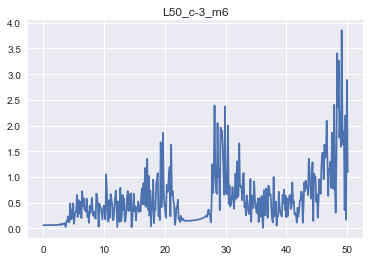

In [147]:
name_list = []
xf_list = []
Nx_list = []
fft_Cxvel_list = []
stdxv_list = []
meanxv_list = []
turb_intens_list = []
conditioned_xvel_list = []

fig = plt.subplots(figsize = (10,6))

for element in csv_list:
    dFrame = pd.read_csv(element)
    if np.any(dFrame.X_position.notnull()):
        
            name = element[108:-4]
            print(name)
            xposition = dFrame.X_position
            start, stop = GetStartStopFrame(xposition)
            
            clipped_df = dFrame[start:stop]
            xf, Nx, fft_Cxvel, stdxv, meanxv, turb_intens, conditioned_xvel = Tortuosity(clipped_df)
            
            name_list.append(name)
            xf_list.append(xf)
            Nx_list.append(Nx)
            fft_Cxvel_list.append(fft_Cxvel)
            stdxv_list.append(stdxv)
            meanxv_list.append(meanxv)
            turb_intens_list.append(turb_intens)
            conditioned_xvel_list.append(conditioned_xvel)
            
            plt.plot(xf, 2.0/Nx * np.abs(fft_Cxvel[0:Nx//2]))
            plt.title(name)
            plt.savefig(figpath + name + '.png')
            plt.show()   
            sb.set()

In [148]:
new_df = (pd.DataFrame({'name' : name_list, 'Nx' : Nx_list,
                            'stdxv': stdxv_list, 'meanxv' : meanxv_list
                       ,'turb_intens' : turb_intens_list}))
other_df = (pd.DataFrame({'xf' : xf_list, 'fft_Cxvel': fft_Cxvel_list, 'filterd_xvel' : conditioned_xvel_list}))

In [149]:
new_df.to_csv(outpath_ + "Tortuosity_Single.csv")
other_df.to_csv(outpath_ + "Tortuosity_Longer.csv")

In [157]:
df = pd.read_csv(outpath_ + "Tortuosity_Single.csv")

name_list = df.name

print(len(name_list))

37


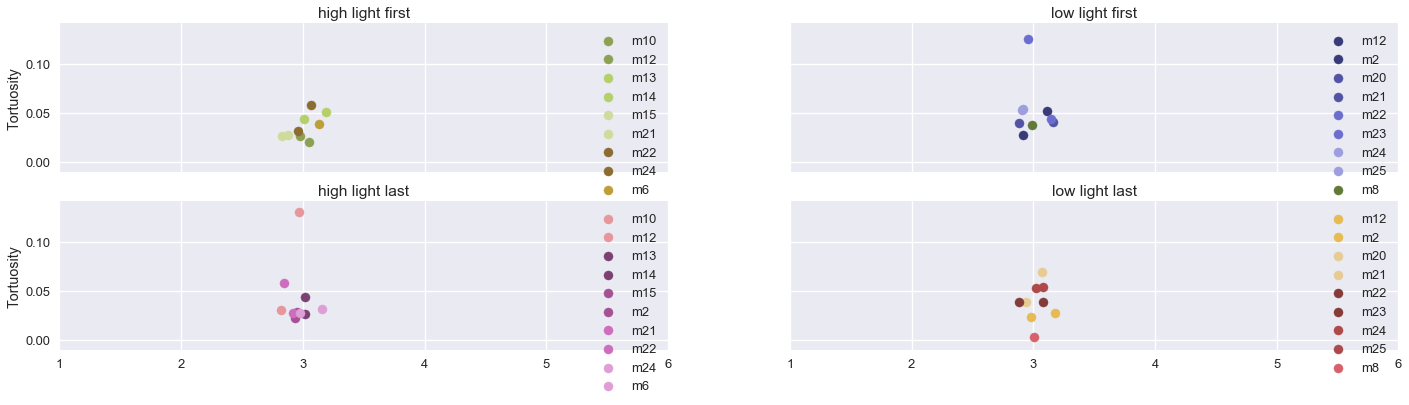

In [271]:
fig, ax = plt.subplots(2,2 , figsize = (24,6), sharex = True, sharey = True)
ax[0,0].set_ylabel('Tortuosity')
ax[1,0].set_ylabel('Tortuosity')
plt.xlim(1,6)
n = len(name_list)
color = cm.tab20b(np.linspace(0,1,n))
for name,c in zip(name_list,color):
    if name.startswith('_L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        j_int = jitter(3)
        ax[0,0].scatter(j_int, Tortuosity, color = c, label = name[9:])
        ax[0,0].legend()
        ax[0,0].set_title('high light first')
#         high light first
    elif name.startswith('_L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        j_int = jitter(3)
        ax[0,1].scatter(j_int, Tortuosity, color = c, label = name[10:])
        ax[0,1].legend() 
        ax[0,1].set_title('low light first')
#         low light first
    elif name.startswith('L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        j_int = jitter(3)
        ax[1,0].scatter(j_int, Tortuosity, color = c, label = name[8:])
        ax[1,0].legend()
        ax[1,0].set_title('high light last')
#         high light last
    elif name.startswith('L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        j_int = jitter(3)
        ax[1,1].scatter(j_int, Tortuosity, color = c, label = name[9:])
        ax[1,1].legend()
        ax[1,1].set_title('low light last')
#         low light last
plt.savefig(outpath_2 + 'jitter.png')

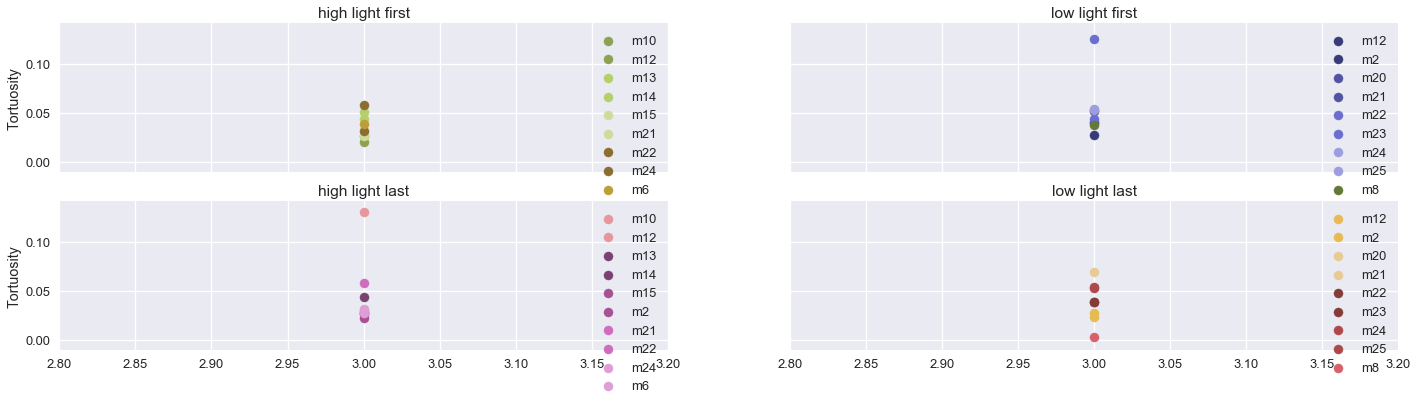

In [272]:
fig, ax = plt.subplots(2,2 , figsize = (24,6), sharex = True, sharey = True)
ax[0,0].set_ylabel('Tortuosity')
ax[1,0].set_ylabel('Tortuosity')
plt.xlim(2.8,3.2)
n = len(name_list)
color = cm.tab20b(np.linspace(0,1,n))
for name,c in zip(name_list,color):
    if name.startswith('_L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[0,0].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[0,0].legend()
        ax[0,0].set_title('high light first')
#         high light first
    elif name.startswith('_L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[0,1].scatter(3, Tortuosity, color = c, label = name[10:])
        ax[0,1].legend() 
        ax[0,1].set_title('low light first')
#         low light first
    elif name.startswith('L50'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[1,0].scatter(3, Tortuosity, color = c, label = name[8:])
        ax[1,0].legend()
        ax[1,0].set_title('high light last')
#         high light last
    elif name.startswith('L0.1'):
        Tortuosity = df[(df.name == name)].turb_intens
        
        ax[1,1].scatter(3, Tortuosity, color = c, label = name[9:])
        ax[1,1].legend()
        ax[1,1].set_title('low light last')
#         low light last
plt.savefig(outpath_2 + 'no_jitter.png')